# Part a) - Ordinary least squares on Franke's function

In [1]:
# --- Imports
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# --- Settings
sns.set_theme(style='whitegrid')
sns.set_palette('viridis')
np.random.seed(42)

In [2]:
def FrankeFunction(x,y): # from project description
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
def MSE_R2_twinx(N, MSE_train, MSE_test, R2_train, R2_test):
    # Plotting MSE and R2 against complexity
    fig, ax1 = plt.subplots()

    line1, = ax1.plot(N[1:], MSE_train, 'bx-', label='MSE train')
    line2, = ax1.plot(N[1:], MSE_test, 'ro--', label='MSE test')
    
    ax2 = ax1.twinx()

    line3, = ax2.plot(N[1:],R2_train, 'gx-', label='R2 train')
    line4, = ax2.plot(N[1:],R2_test, 'yo--', label='R2 test')

    # Label
    lines = [line1, line2, line3, line4]
    labels = (line.get_label() for line in lines)
    ax1.legend(lines, labels, loc='center right', fancybox=True)
    
    ax2.grid(False)
    plt.show()

In [4]:
def polynomial_matrix_2D(x, y, p, no_intercept=True):
	"""Variables x and y, degree p, returns design matrix"""
	n = len(x) # number of data points
	if p == 0: return np.ones((n,1))

	l = int((p+1)*(p+2)/2) # number of elements in beta
	X = np.zeros((n,l-no_intercept))

	idx = int(not no_intercept)
	for degree in range(1,p+1):
		for ydegree in range(degree+1):
			X[:, idx] = (x**(degree - ydegree)) * (y**ydegree)
			idx += 1
		
	return X

In [5]:
# --- Generating dataset
n = 100 # the square root of the number of datapoints
x, y = np.linspace(0,1,n), np.linspace(0,1,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

k = .1 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise

# --- Creating design matrix
p = 5 # highest polynomial degree
N = np.arange(p+1) # for looping
L = [int((p+1)*(p+2)/2) for p in N] # beta lengths for plotting later
l = L[-1] # greatest beta length

# --- Loop
MSE_OLS_train, MSE_OLS_test = np.zeros(p), np.zeros(p)
R2_OLS_train, R2_OLS_test = np.zeros(p), np.zeros(p)
beta_values = np.zeros((p+1,l))

for i in N:
    # Constructing the design matrix
    X = polynomial_matrix_2D(x, y, i, no_intercept=True) # degree i, no intercept

    # Splitting the data (note that y_... has nothing to do with y)
    X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=3)

    # Scaling the data (only centering)
    y_train_mean = np.mean(y_train)
    y_train_centered = y_train - y_train_mean
    intercept = y_train_mean # recovering intercept, which is just y_train_mean due to centering

    if i == 0: beta_values[0,0] = intercept; continue # degree 0 case

    X_train_mean = np.mean(X_train, axis=0) # 1D array of each column mean
    X_train_centered = X_train - X_train_mean
    X_test_centered = X_test - X_train_mean # centering with training data

    # Solving OLS
    beta_OLS = np.linalg.inv(X_train_centered.T @ X_train_centered) @ X_train_centered.T @ y_train_centered

    y_tilde_OLS = X_train_centered @ beta_OLS + intercept # predictor on training data
    y_predict_OLS = X_test_centered @ beta_OLS + intercept # predictor on test data

    MSE_OLS_train[i-1] = mean_squared_error(y_tilde_OLS, y_train)
    MSE_OLS_test[i-1] = mean_squared_error(y_predict_OLS, y_test)
    R2_OLS_train[i-1] = r2_score(y_tilde_OLS, y_train)
    R2_OLS_test[i-1] = r2_score(y_predict_OLS, y_test)

    beta_values[i,0] = intercept
    beta_values[i,1:L[i]] = beta_OLS.T

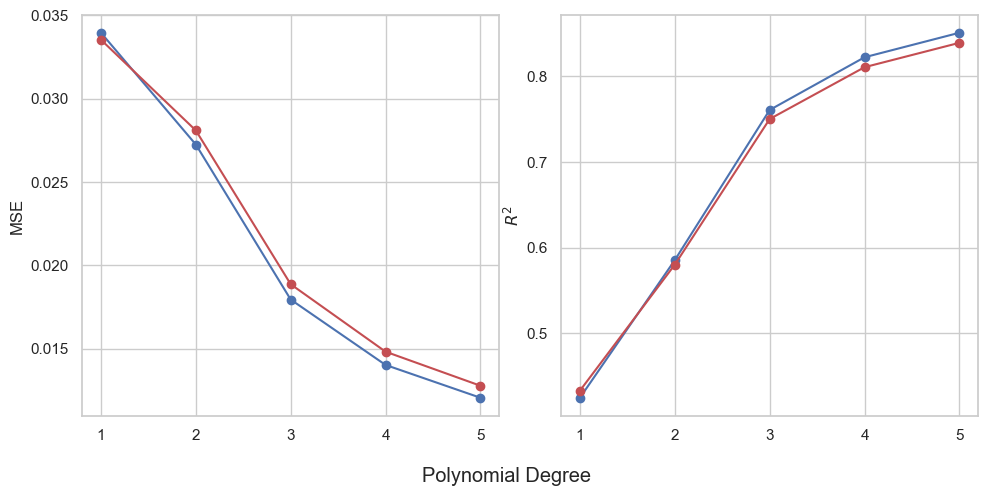

In [32]:
# Plotting OLS MSE and R2 against complexity
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True); fig.tight_layout()

axs[0].plot(N[1:], MSE_OLS_train, 'bo-', label='train')
axs[0].plot(N[1:], MSE_OLS_test, 'ro-', label='test')
axs[0].set_ylabel('MSE')

axs[1].plot(N[1:], R2_OLS_train, 'bo-', label='train')
axs[1].plot(N[1:], R2_OLS_test, 'ro-', label='test')
axs[1].set_ylabel(r'$R^2$')

fig.supxlabel('Polynomial Degree')
plt.subplots_adjust(left=0.075, bottom=0.15)
plt.xticks(list(range(1, 6)))

plt.show()

### Plotting the beta parameters

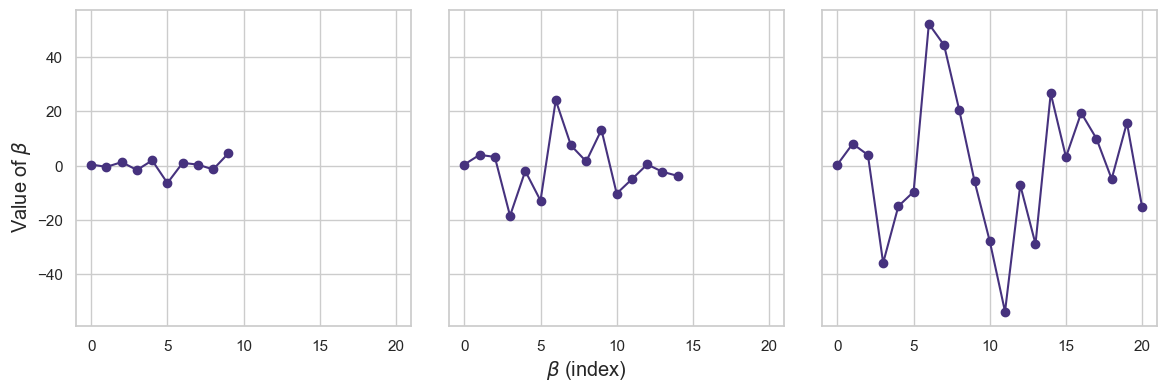

In [36]:
# Plotting beta coefficients
fig, axs = plt.subplots(1,3, figsize=(12, 4), sharex=True, sharey=True); fig.tight_layout()
axs = axs.flatten()

for i,l in enumerate(L):
    if i < 3: continue
    axs[i-3].plot(np.arange(l), beta_values[i][:l], 'o-')

fig.supxlabel(r'$\beta$ (index)')
fig.supylabel(r'Value of $\beta$')

plt.subplots_adjust(left=0.075, bottom=0.15)
plt.show()